# LAN Tutorial


This tutorial is a rather comprehensive introduction to **HDDM** with focus on the new **LAN extension**.
The methods behind the **new** `HDDMnn()`, `HDDMnnRegressor()` and `HDDMnnStimcoding()` classes can be found in our original dedicated [publication](https://elifesciences.org/articles/65074).
These are new featues. Please let us know on the HDDM forum and/or via github reports regarding bugs or other limitations and we will do our best to help as soon as we can.

## Things to look out for:
 
 - Networks were trained over a fairly wide range of parameters which hopefully capture the scope of common empirical data. The networks will not accurately report likelihoods outside that range, so we explicitly limit the range of parameters that can be sampled from. If you find that your posterior samples reach and get stuck at the allowed parameter bounds (which you will see in the posterior plots), please notify us and we will do our best to provide improved networks over time. 

- You may encounter more print output than with standard HDDM. These are sanity checks and the verbosity will vanish progressively.

## Section 0: Colab Prep (Optional)

### Reminder
In the *upper left* menu click on **Runtime**, then **Change runtime type** and select **GPU** as **hardware accelerator**

### INSTALLATION COLAB: INSTALL SUPPORT LIBRARIES

In [1]:
# Note: Usually colab has all other packages which we may use already installed
# The basic configuration of colabs does change over time, so you may have to add
# some install commands here if imports below don't work for package xyz
!pip install scikit-learn
!pip install cython
!pip install pymc==2.3.8

### INSTALLATION COLAB:  INSTALL HDDM

In [ ]:
!pip install -U --no-deps git+https://github.com/hddm-devs/hddm
!pip install -U --no-deps git+https://github.com/hddm-devs/kabuki

  Cloning https://github.com/hddm-devs/hddm to /private/var/folders/gx/s43vynx550qbypcxm83fv56dzq4hgg/T/pip-req-build-xzqqwrcn
  Running command git clone -q https://github.com/hddm-devs/hddm /private/var/folders/gx/s43vynx550qbypcxm83fv56dzq4hgg/T/pip-req-build-xzqqwrcn
  Running command git submodule update --init --recursive -q

### Imports

In [1]:
# MODULE IMPORTS ----

# warning settings
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

# Data management
import pandas as pd
import numpy as np
import pickle

# Plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# Stats functionality
from statsmodels.distributions.empirical_distribution import ECDF

# HDDM
import hddm
from hddm.simulators.hddm_dataset_generators import simulator_h_c

## Section 1: Model Info / Simulation / Basic Plotting

The main concern of this notebook is to present the extended capabilities of the HDDM toolbox as a result of the new `HDDMnn` classes.

Primarily we are interested in the additional models we can now be fit to data. So let's take stock of the models that were added to standard **HDDM**.

### 2-Choice Models

#### ANGLE

A model with a linearly collapsing angle. Adds a parameter $\theta$, which specifies the angle of the bound.

#### WEIBULL

A model that includes a collapsing bound parameterized as the scaled *cdf* of a Weibull distribution.
This adds two parameters to the standard **DDM**, $\alpha$ and $\beta$.

#### LEVY

The Levy model is essentially a standard **DDM** where noise is not driven by a Gaussian distribution, but the noise process is now parameterized by the new parameter $\alpha$, which interpolates between a Gausian $\alpha = 2$ and a Cauchy (heavy tailed) $\alpha = 1$. 

#### ORNSTEIN

This model implements the 2-choice **LCA**, which includes a an inhibition / excitation parameter $g$. 

Find more details on these models in our companion [paper](https://elifesciences.org/articles/65074). 

### 3 / 4-Choice Models

#### NOTE
The addition of *3 choice* and *4 choice* models, comes with slightly more limited functionality as compared to *2 choice* models. Specifically, not all plot-concepts currently standard in **HDDM** translate immediately to models with more choice options. We are trying to align this functionality going forward.

#### LCA (Leaky Competing Accumulator)
Please find the original description in this [paper](https://pubmed.ncbi.nlm.nih.gov/11488378/).

#### RACE
Race models simply take out the mutual and self-inhibition of **LCAs**.

#### ANGLE versions of LCA / RACE
Implements an linearly collapsing bound as above under the respective *2 choice models*


### 1.1 Access Meta-Data

Let's first take a look at some of the useful metadata we can use to set up our models and simulators. 
If we type ```hddm.simulators.model_config```, we get back a dictionary that stores a bunch of information
for each of the models that are currently implemented in HDDM. It lists,

- A ```doc``` string that gives some information about the status of the model as it pertains to it's usability as well as some potential usage tips. Please read the ```doc``` string before using any of the new models.
- The parameter names under ```params```,
- The parameter bounds that where used for training the network under ```param_bounds```
- The boundary_function (```boundary```) 
- Default parameter values (```params_default```). 
- Slice sampler settings by parameter (```slice_widths```)
- Under ```params_trans``` you can choose parameters which will be logit transformed for sampling (order as in ```params```)
- ```choices``` determines valid choice options under the model
- Under  ```hddm_include```, it lists the parameters which we want to include when initializing our HDDM Model with one of the sequential sampling models available.


You won't need most of these options if you are getting started, but they do provide you with useful information and a couple extra degrees of freedom when it comes to optimizing your sampler.


In [2]:
# List the models currently available
hddm.model_config.model_config.keys()

dict_keys(['ddm_hddm_base', 'full_ddm_hddm_base', 'ddm', 'angle', 'weibull', 'levy', 'full_ddm', 'ornstein', 'ddm_sdv', 'gamma_drift', 'gamma_drift_angle', 'ds_conflict_drift', 'ds_conflict_drift_angle', 'ddm_par2', 'ddm_par2_no_bias', 'ddm_par2_angle_no_bias', 'ddm_par2_weibull_no_bias', 'ddm_seq2', 'ddm_seq2_no_bias', 'ddm_seq2_angle_no_bias', 'ddm_seq2_weibull_no_bias', 'ddm_mic2_adj', 'ddm_mic2_adj_no_bias', 'ddm_mic2_adj_angle_no_bias', 'ddm_mic2_adj_weibull_no_bias', 'race_no_bias_3', 'race_no_bias_angle_3', 'race_no_bias_4', 'race_no_bias_angle_4', 'lca_no_bias_3', 'lca_no_bias_angle_3', 'lca_no_bias_4', 'lca_no_bias_angle_4', 'weibull_cdf', 'full_ddm2'])

#### NOTE

You find **two kinds of extra** models which were not mentioned in the model listing above:

1. Experimental models, which eventually will be fully documented (or dropped)
2. `hddm_base` models are used predominantly with the basic `HDDM()` classes. These models are **not** to be used with the `HDDMnn()` classes.

Now taking a closer look at the ```angle``` model

In [3]:
# Metadata
model = "ddm"
n_samples = 1000

In [4]:
# Config for our current model
hddm.model_config.model_config[model]

{'doc': 'Basic DDM. Meant for use with the LAN extension. \nNote that the boundaries here are coded as -a, and a in line with all other models meant for the LAN extension. \nTo compare model fits between standard HDDM and HDDMnn when using the DDM model, multiply the boundary (a) parameter by 2. \nWe recommend using standard HDDM if you are interested in the basic DDM, but you might want to use this for testing.',
 'params': ['v', 'a', 'z', 't'],
 'params_trans': [0, 0, 1, 0],
 'params_std_upper': [1.5, 1.0, None, 1.0],
 'param_bounds': [[-3.0, 0.3, 0.1, 0.001], [3.0, 2.5, 0.9, 2.0]],
 'boundary': <function hddm.simulators.boundary_functions.constant(t=0)>,
 'params_default': [0.0, 1.0, 0.5, 0.001],
 'hddm_include': ['z'],
 'choices': [-1, 1],
 'slice_widths': {'v': 1.5,
  'v_std': 1,
  'a': 1,
  'a_std': 1,
  'z': 0.1,
  'z_trans': 0.2,
  't': 0.01,
  't_std': 0.15}}

In [5]:
# Looking at the doc string before using the model
print(hddm.model_config.model_config[model]["doc"])

Basic DDM. Meant for use with the LAN extension. 
Note that the boundaries here are coded as -a, and a in line with all other models meant for the LAN extension. 
To compare model fits between standard HDDM and HDDMnn when using the DDM model, multiply the boundary (a) parameter by 2. 
We recommend using standard HDDM if you are interested in the basic DDM, but you might want to use this for testing.


### 1.2 Generate Data
Let's start by generating some data from the ```angle``` model. For this you have available the ```simulators``` module, specifically we will start with the ```simulator_h_c``` function.
If you are curious about all the capabilities of this function, please check the `help()` function for it.

In [6]:
from hddm.simulators.hddm_dataset_generators import simulator_h_c

data, full_parameter_dict = simulator_h_c(
    n_subjects=1,
    n_trials_per_subject=n_samples,
    model=model,
    p_outlier=0.00,
    conditions=None,
    depends_on=None,
    regression_models=None,
    regression_covariates=None,
    group_only_regressors=False,
    group_only=None,
    fixed_at_default=None,
)

A quick look into what the simulator spits out (you can also read about it in the docs).  <br/><br/>
We get back a ```tuple``` of two:

- *First*, a DataFrame which holds a ``rt``, a `response` and a ```subj_idx``` column as well as trial-by-trial ground truth parameters. 

- *Second* a parameter dictionary which has parameter names in accordance with `HDDM()` trace names. This is useful for some of our plots.

In [7]:
data

,rt,response,subj_idx,v,a,z,t
0,1.956185,1.0,0,-0.481731,0.655642,0.439841,0.887191
1,1.035191,0.0,0,-0.481731,0.655642,0.439841,0.887191
2,1.004191,0.0,0,-0.481731,0.655642,0.439841,0.887191
3,1.510186,0.0,0,-0.481731,0.655642,0.439841,0.887191
4,1.164191,0.0,0,-0.481731,0.655642,0.439841,0.887191
...,...,...,...,...,...,...,...
995,1.697184,0.0,0,-0.481731,0.655642,0.439841,0.887191
996,1.520186,1.0,0,-0.481731,0.655642,0.439841,0.887191
997,1.552186,0.0,0,-0.481731,0.655642,0.439841,0.887191
998,1.038191,0.0,0,-0.481731,0.655642,0.439841,0.887191


In [8]:
# Here unspectacularly, parameter names are unchanged
# (single subject fits do not need any parameter name augmentation)
full_parameter_dict

{'v': -0.48173086489284433,
 'a': 0.6556418306610691,
 't': 0.8871907031605131,
 'z': 0.4398408702789776}

### 1.2 First Plot 

Now that we have our simulated data, we look to visualise it.
Let's look at a couple of plots that we can use for this purpose. 

The `HDDM.plotting` module includes the `plot_from_data` function, which allows you to plot 
subsets from a dataset, according to a grouping specified by the `groupby` argument.

The plot creates a `matplotlib.axes` object for each subset, and you can provide a function to manipulate 
this axes object. Some of these *axes manipulators* are provided your you. Here we focus on the 
`_plot_func_model` *axes manipulator* supplied under the `plot_func` argument.

Check out the arguments of `plot_from_data` and `_plot_func_model` using the `help()` function.
You have quite some freedom in styling these plots.

We will refer to this plot as the `model cartoon plot`.

- The top histogram refers to the probability of choosing option $1$ across time.
- The bottom (upside-down) histogram refers to the probability of choosing option $-1$ (may be coded as $0$ as well) across time.


subj_idx(0)


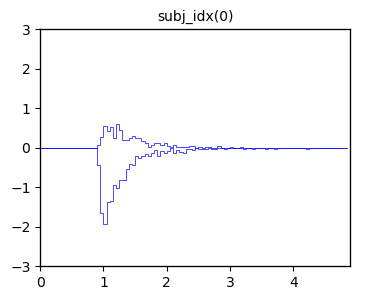

In [9]:
hddm.plotting.plot_from_data(
    df=data,
    generative_model=model,
    columns=1,
    groupby=["subj_idx"],
    figsize=(4, 3),
    value_range=np.arange(0, 5, 0.1),
    plot_func=hddm.plotting._plot_func_model,
    **{"alpha": 1.0, "ylim": 3, "add_data_rts": True, "add_data_model": False}
)
plt.show()

If we set `add_model = True`, this will add a cartoon of the model on top of the histograms. 

#### CAUTION
This `model cartoon plot` will only work for *2-choice models* for now.

Moreover, often useful for illustration purposes, we can include a bunch of simulations trajectories into the model plot (note the corresponding arguments). Common to all models currently included is their conceptual reliance on there particle trajectories. Reaction times and choices are simulated as *boundary crossings* of these particles. If you don't want to include these trajectories, just set `show_trajectories = False`.

subj_idx(0)


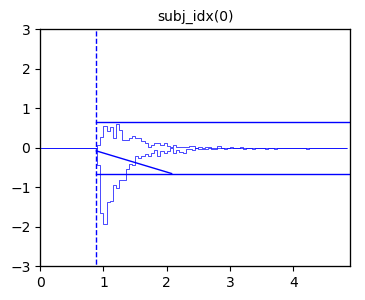

In [10]:
hddm.plotting.plot_from_data(
    df=data,
    generative_model=model,
    columns=1,
    groupby=["subj_idx"],
    figsize=(4, 3),
    value_range=np.arange(0, 5, 0.1),
    plot_func=hddm.plotting._plot_func_model,
    **{"alpha": 1.0, "ylim": 3, "add_data_rts": True, "add_data_model": True}
)
plt.show()

If you are interested, you can use this plot to investigate the behavior of models across different parameters setups.

## Section 2: Single Subject (or collapsed) Data


Now, we try to fit these models to data! Let's start with an simple dataset. In other words, we have one single participant who provides  $n$ datatpoints (reaction times and choices) from some *two alternative forced choice* task paradigm.


### Note

In this demo we fit to simulated data. This serves as a template, and you can easily adapt it to your needs. 

In [5]:
# Metadata
nmcmc = 1500
model = "angle"
n_samples = 1000
includes = hddm.model_config.model_config[model]["hddm_include"]

### Note

When defining `includes`,
you can also pick only as subset of the parameters suggested under `hddm.model_config.model_config`.


In [6]:
# Generate some simulatred data
from hddm.simulators.hddm_dataset_generators import simulator_h_c

data, full_parameter_dict = simulator_h_c(
    n_subjects=1,
    n_trials_per_subject=n_samples,
    model=model,
    p_outlier=0.00,
    conditions=None,
    depends_on=None,
    regression_models=None,
    regression_covariates=None,  # need this to make initial covariate matrix from which to use dmatrix (patsy)
    group_only_regressors=False,
    group_only=None,
    fixed_at_default=None,
)

In [7]:
data

,rt,response,subj_idx,v,a,z,t,theta
0,2.096904,0.0,0,-1.688219,1.945201,0.543195,1.33591,0.875893
1,2.154903,0.0,0,-1.688219,1.945201,0.543195,1.33591,0.875893
2,1.862907,0.0,0,-1.688219,1.945201,0.543195,1.33591,0.875893
3,1.847907,0.0,0,-1.688219,1.945201,0.543195,1.33591,0.875893
4,1.927906,0.0,0,-1.688219,1.945201,0.543195,1.33591,0.875893
...,...,...,...,...,...,...,...,...
995,2.260902,1.0,0,-1.688219,1.945201,0.543195,1.33591,0.875893
996,1.895906,0.0,0,-1.688219,1.945201,0.543195,1.33591,0.875893
997,1.782908,0.0,0,-1.688219,1.945201,0.543195,1.33591,0.875893
998,1.864907,0.0,0,-1.688219,1.945201,0.543195,1.33591,0.875893


In [8]:
# Define the HDDM model
hddmnn_model = hddm.HDDMnn(
    data,
    informative=False,
    include=includes,
    p_outlier=0.01,
    w_outlier=0.1,
    model=model,
)

Supplied model_config specifies params_std_upper for  z as  None.
Changed to 10


In [9]:
# Sample
hddmnn_model.sample(nmcmc, burn=500)

 [-----------------100%-----------------] 1500 of 1500 complete in 103.2 sec

### 2.1 Visualization

The `plot_caterpillar()` function below displays *parameterwise*, 

-  as a <span style="color:blue"> **blue** </span> tick-mark the **ground truth**.
-  as a *thin* **black** line the $1 - 99$ percentile range of the posterior distribution
-  as a *thick* **black** line the $5-95$ percentile range of the posterior distribution

Again use the ```help()``` function to learn more.

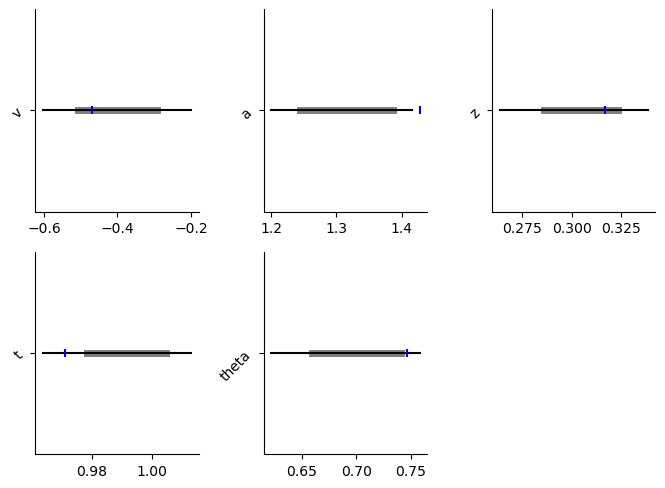

In [21]:
# Caterpillar Plot: (Parameters recovered ok?)
hddm.plotting.plot_caterpillar(
    hddm_model=hddmnn_model,
    ground_truth_parameter_dict=full_parameter_dict,
    figsize=(8, 5),
    columns=3,
)

plt.show()

### 2.1.1 Posterior Predictive (via `model cartoon plot`)
Another way to examine whether or not our recovery was satisfactory is to perform posterior predictive checks. Essentially, we are looking to simulate datasets from the trace and check whether it aligns with the ground truth participant data. This answers the question of whether or not these parameters that you recovered can actually reproduce the data. 

Use the `plot_posterior_predictive()` function in the `plotting` module for this. It is structured just like the `plot_from_data()` function, but instead of providing a *dataset*, you supply a *hddm model*.

Use the `help()` function to check out all the functionality.

passing


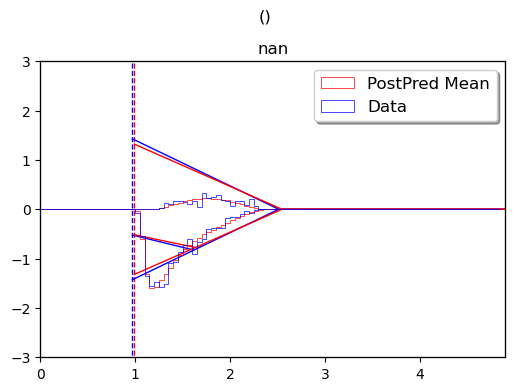

In [22]:
hddm.plotting.plot_posterior_predictive(
    model=hddmnn_model,
    columns=1,
    groupby=["subj_idx"],
    figsize=(6, 4),
    value_range=np.arange(0, 5, 0.1),
    plot_func=hddm.plotting._plot_func_model,
    parameter_recovery_mode=True,
    **{"alpha": 0.01, "ylim": 3, "samples": 200}
)
plt.show()

**A small note on convergence**:

Note that the MCMC algorithm requires the chain to converge. There are many heuristics that help you identifying problems with convergence, such as the trace plot, auto correlation plot, and marginal posterior histogram. In the trace plots, there might be a problem if you see large jumps. In the autocorrelation plot, there might be a problem if it does not drop rapidly. The `HDDMnn()` classes support the computation of the *Gelman-Rubin*, *r-hat* statistic, as you would with any `hddm` model. Generally, by extracting the traces, you are free to compute any convergence statistics you want of course. 

Plotting v
Plotting a
Plotting z
Plotting t
Plotting theta


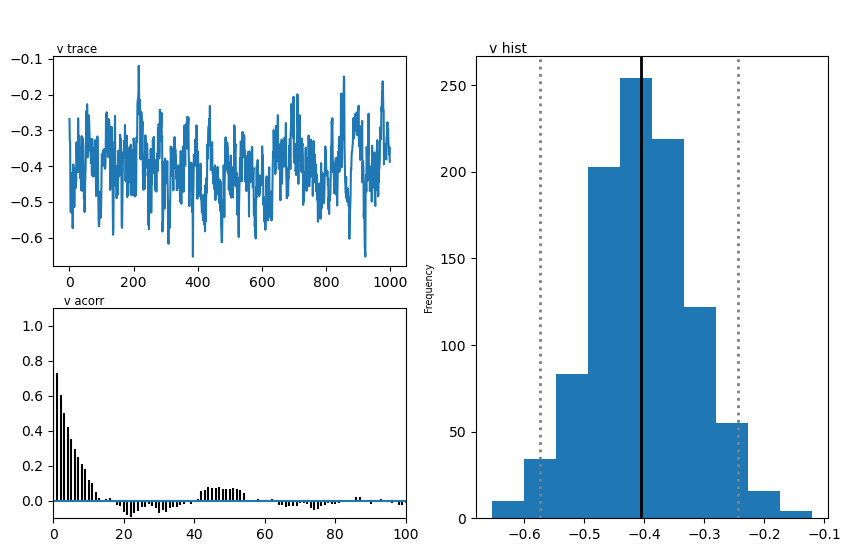

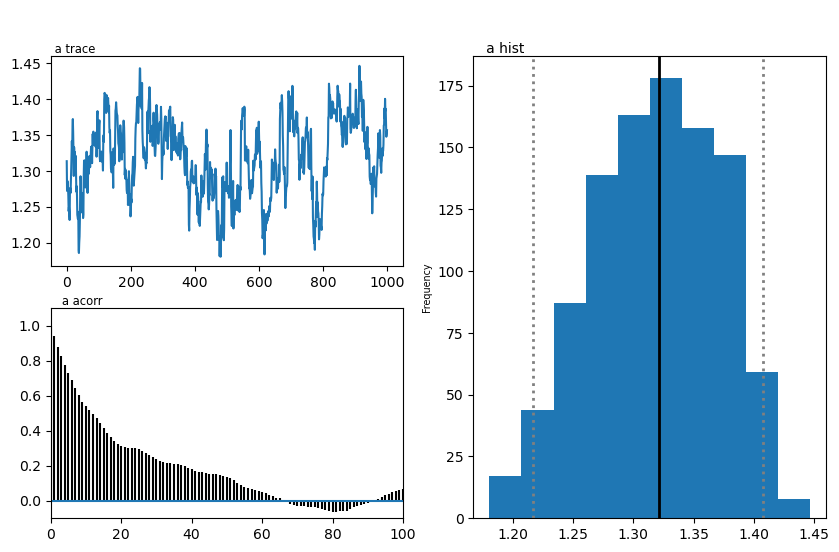

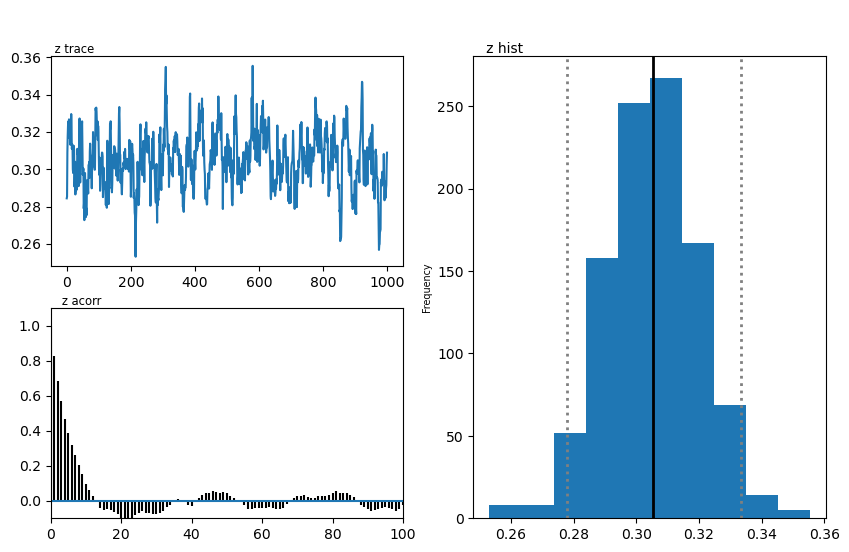

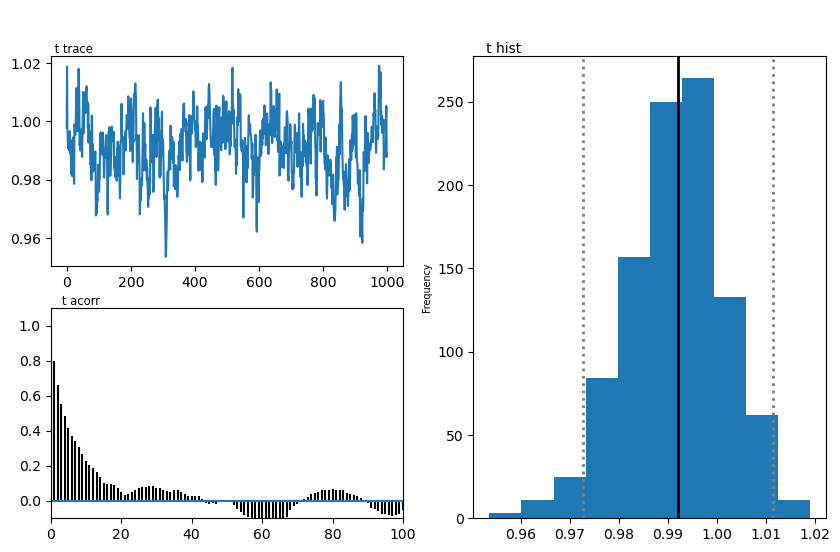

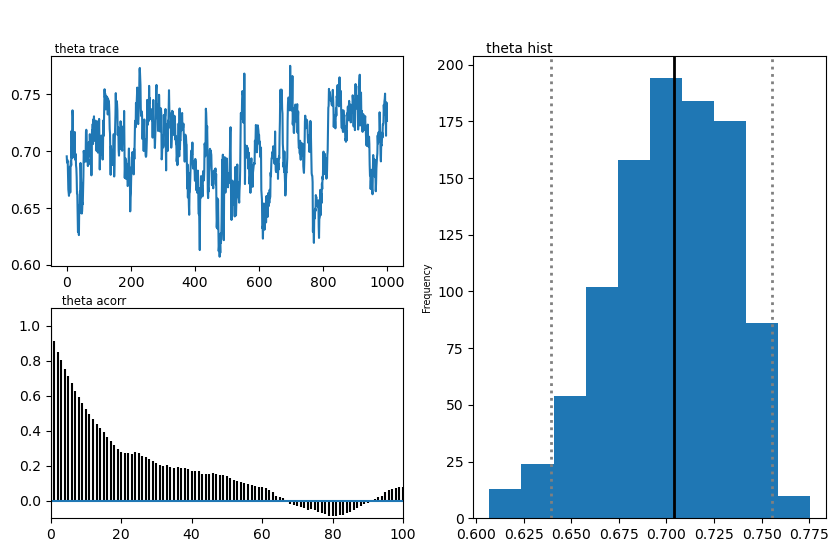

In [23]:
# TAKING A LOOK AT THE POSTERIOR TRACES
hddmnn_model.plot_posteriors(hddm.simulators.model_config[model]["params"])
plt.show()

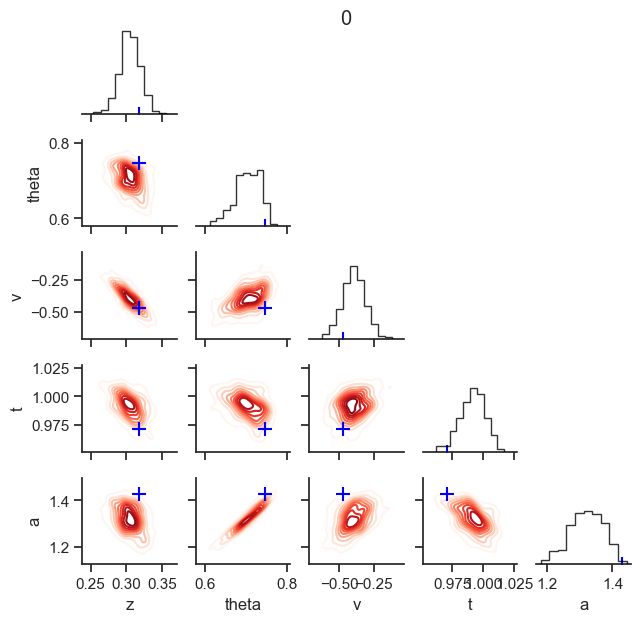

In [24]:
hddm.plotting.plot_posterior_pair(
    hddmnn_model, save=False, parameter_recovery_mode=True, samples=500, figsize=(6, 6)
)

## Section 3: Hierarchical Models

The 'h' in `hddm` stands for hierarchical, so let's do it! If we have data from multiple participants and we assume that the parameters of single participants are drawn from respective **group** or **global** distributions, we can model this explicitly in `hddm` by specifying `is_group_model = True`.

Implicitly we are fitting a model of the following kind,

$$p(\{\theta_j\}, \{\theta_g\} | \mathbf{x}) \propto \left[ \prod_j^{J} \left[ \prod_i^{N_j} p(x_i^j | \theta_j) \right] p(\theta_j | \theta_g) \right] p( \theta_g | \theta_h )$$

where (let's say for the **angle model**),

1. $\theta_j = \{v_j, a_j, z_j, t_j, \theta_j \}$, are the model parameters for **subject j**.

2. $\theta_g = \{v_g^{\mu}, a_g^{\mu}, z_g^{\mu}, t_g^{\mu}, \theta_g^{\mu}, v_g^{\sigma}, a_g^{\sigma}, z_g^{\sigma}, t_g^{\sigma}, \theta_g^{\sigma} \}$ (scary, but for completeness), are the **mean** and **variance** parameters for our group level normal distributions, and $\{ \theta_h \}$ are **fixed hyperparameters**.

3. $x_i^j = \{rt_i^j, c_i^j \}$, are the **choice and reaction time**  of **subject j** during **trial i**.

In words, the right hand side of the equation tells us that we have a **global parameter distribution** with certain **means** and **variances** for each parameter (we want to figure these means and variances out), from which the **subject level parameters** are drawn and finally **subject level datapoints** follow the likelihood distribution of our **ddm / angle / weibull / you name it** mdoels.

In [6]:
# Metadata
nmcmc = 1000
model = "angle"
n_trials_per_subject = 200
n_subjects = 10

In [7]:
# test regressors only False
# add p_outliers to the generator !
data, full_parameter_dict = simulator_h_c(
    data=None,
    n_subjects=n_subjects,
    n_trials_per_subject=n_trials_per_subject,
    model=model,
    p_outlier=0.00,
    conditions=None,
    depends_on=None,
    regression_models=None,
    regression_covariates=None,
    group_only_regressors=False,
    group_only=None,
    fixed_at_default=None,
)

In [8]:
hddmnn_model = hddm.HDDMnn(
    data,
    model=model,
    informative=False,
    is_group_model=True,
    include=hddm.simulators.model_config[model]["hddm_include"],
    p_outlier=0.0,
)

{'v': 1.5, 'v_std': 1, 'a': 1, 'a_std': 1, 'z': 0.1, 'z_trans': 0.2, 't': 0.01, 't_std': 0.15, 'theta': 0.1, 'theta_std': 0.2}
Supplied model_config specifies params_std_upper for  z as  None.
Changed to 10


In [9]:
hddmnn_model.sample(
    nmcmc, burn=100
)  # if you want to save the model specify extra arguments --> dbname='traces.db', db='pickle'. # hddmnn_model.save('test_model')

 [-----------------100%-----------------] 1000 of 1000 complete in 339.0 sec

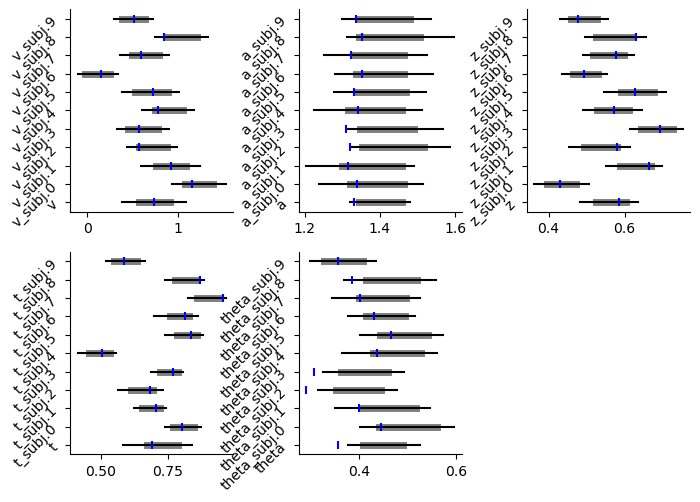

In [12]:
# Caterpillar Plot: (Parameters recovered ok?)
hddm.plotting.plot_caterpillar(
    hddm_model=hddmnn_model,
    ground_truth_parameter_dict=full_parameter_dict,
    figsize=(8, 5),
    columns=3,
)

plt.show()

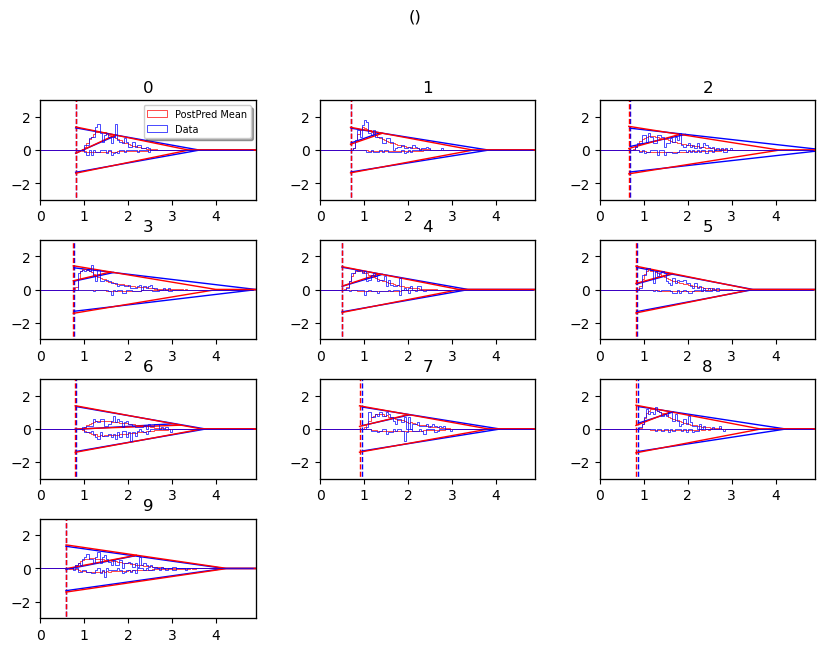

In [11]:
hddm.plotting.plot_posterior_predictive(
    model=hddmnn_model,
    columns=3,
    figsize=(10, 7),
    groupby=["subj_idx"],
    value_range=np.arange(0, 5, 0.1),
    plot_func=hddm.plotting._plot_func_model,
    parameter_recovery_mode=True,
    **{
        "alpha": 0.01,
        "ylim": 3,
        "add_posterior_mean_rts": True,
        "add_posterior_mean_model": True,
        "add_posterior_uncertainty_rts": False,
        "add_posterior_uncertainty_model": False,
        "samples": 200,
        "legend_fontsize": 7.0,
    }
)

## Section 4: Parameter varies by Condition 

An important aspect of these posterior analysis, is the consideration of experiment design.
We may have an experiment in which subject are exposed to a variety of conditions, 
such as for example different degrees of difficulty of the same task

It is often reasonable to assume that all but the conceptually relevant parameters are common across conditions.

As a by-product, such experiment designs can help us with the recovery of the constant parameters, by probing those static aspects of the model across varying kinds of datasets (driven by targeted manipulation of variable aspects of the model).

Implicitly we fit the following kind of model,

$$p( \{\theta_c \}, \theta | \mathbf{x} ) \propto  \left[ \prod_c^C  \left[ \prod_i^{N_i} p( x_i^c | \theta_c, \theta ) \right] p(\theta_c)  \right] p(\theta)$$


Where $\theta_c$ is the condition dependent part of the parameter space, and $\theta$ forms the portion of parameters which remain constant across condtions. 

To give a more concrete example involving the **weibull model**, consider a dataset for a single participant, who went through four conditions of an experiment. Think of the conditions as manipulating the payoff structure of the experiment to incentivize / disincentivize accuracy in favor of speed. We operationalize this by treating the $a$ parameter, the initial boundary separation, as affected by the manipulation, while the rest of the parameters are constant across all experiment conditions.

The resulting model would be of the form, 

$$ p( {a_c}, v, z, t, \alpha, \beta | x ) \propto \left[ \prod_c^C  \left[ \prod_i^{N_c} p( x_i^c | a_c, v, z, t, \alpha, \beta)  \right] p(a_c) \right]  p(v, z, t, \alpha, \beta)$$ 

In [33]:
# Metadata
nmcmc = 1000
model = "angle"
n_trials_per_subject = 500

# We allow the boundary conditions to vary
depends_on = {"a": ["c_one"]}

# They will depend on a fictious column 'c_one' that specifies
# levels / conditions
conditions = {"c_one": ["low", "medium", "high"]}

In [34]:
data, full_parameter_dict = simulator_h_c(
    n_subjects=1,
    n_trials_per_subject=n_trials_per_subject,
    model=model,
    p_outlier=0.00,
    conditions=conditions,
    depends_on=depends_on,
    regression_models=None,
    regression_covariates=None,
    group_only_regressors=False,
    group_only=None,
    fixed_at_default=None,
)

depends_on is:  {'a': ['c_one']}


In [35]:
# Let's check the resulting parameter vector
full_parameter_dict

{'theta': 0.7406253194726012,
 'v': 1.464554358239174,
 'z': 0.6206249211841304,
 't': 1.534252965986117,
 'a(high)': 1.0519165572885651,
 'a(low)': 1.2561997135872933,
 'a(medium)': 0.9265856569938499}

In [36]:
# Make HDDM Model
hddmnn_model = hddm.HDDMnn(
    data,
    model=model,
    informative=False,
    include=hddm.simulators.model_config[model]["hddm_include"],
    p_outlier=0.0,
    is_group_model=False,
    depends_on=depends_on,
)

In [37]:
# Sample
hddmnn_model.sample(nmcmc, burn=100)

 [-----------------100%-----------------] 1001 of 1000 complete in 129.4 sec

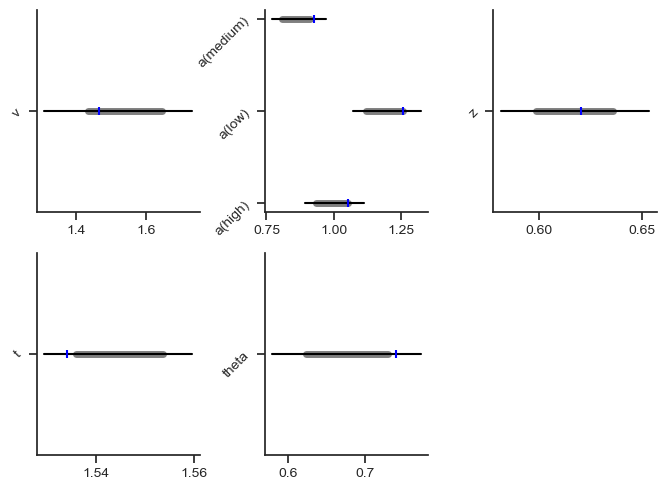

In [39]:
# Caterpillar Plot: (Parameters recovered ok?)
hddm.plotting.plot_caterpillar(
    hddm_model=hddmnn_model,
    ground_truth_parameter_dict=full_parameter_dict,
    figsize=(8, 5),
    columns=3,
)

plt.show()

passing


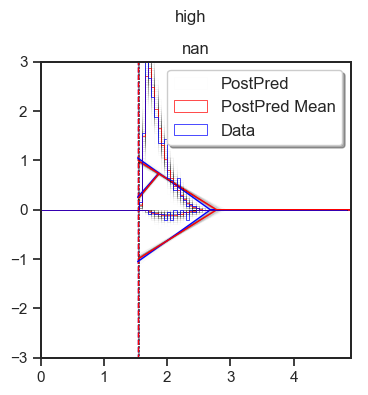

passing


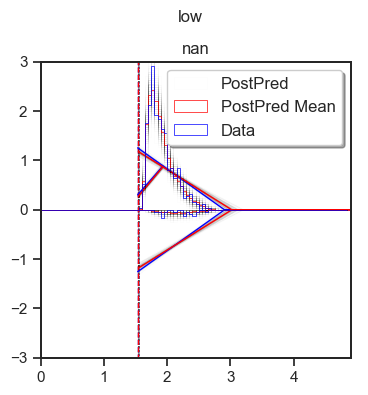

passing


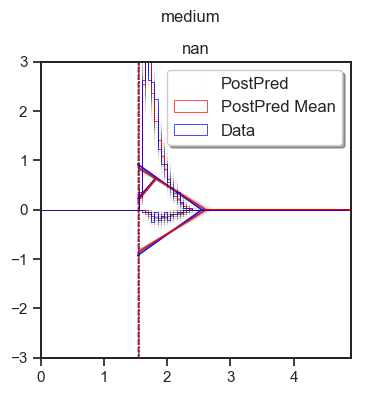

In [40]:
hddm.plotting.plot_posterior_predictive(
    model=hddmnn_model,
    columns=1,
    groupby=["subj_idx"],
    figsize=(4, 4),
    value_range=np.arange(0, 5, 0.1),
    plot_func=hddm.plotting._plot_func_model,
    parameter_recovery_mode=True,
    **{
        "alpha": 0.01,
        "ylim": 3,
        "add_posterior_uncertainty_rts": True,
        "add_posterior_uncertainty_model": True,
        "samples": 200,
    }
)
plt.show()

### 4.1 Combine Hierarchical and Condition data

In [41]:
# Metadata
nmcmc = 1500
model = "angle"
n_subjects = 5
n_trials_per_subject = 500

In [42]:
data, full_parameter_dict = simulator_h_c(
    n_subjects=n_subjects,
    n_trials_per_subject=n_trials_per_subject,
    model=model,
    p_outlier=0.00,
    conditions={
        "c_one": ["low", "medium", "high"]
    },  # , 'c_three': ['low', 'medium', 'high']},
    depends_on={
        "v": ["c_one"]
    },  # 'theta': ['c_two']}, # 'theta': ['c_two']}, #regression_models = None, #
    regression_models=None,  # regression_covariates = None,
    regression_covariates=None,  # need this to make initial covariate matrix from which to use dmatrix (patsy)
    group_only_regressors=False,
    group_only=None,
    fixed_at_default=None,
)

depends_on is:  {'v': ['c_one']}


In [43]:
# Make HDDM Model
hddmnn_model = hddm.HDDMnn(
    data,
    model=model,
    informative=False,
    include=hddm.simulators.model_config[model]["hddm_include"],
    p_outlier=0.0,
    is_group_model=True,
    depends_on={"v": "c_one"},
)

In [44]:
hddmnn_model.sample(nmcmc, burn=100)

 [-----------------100%-----------------] 1500 of 1500 complete in 919.0 sec

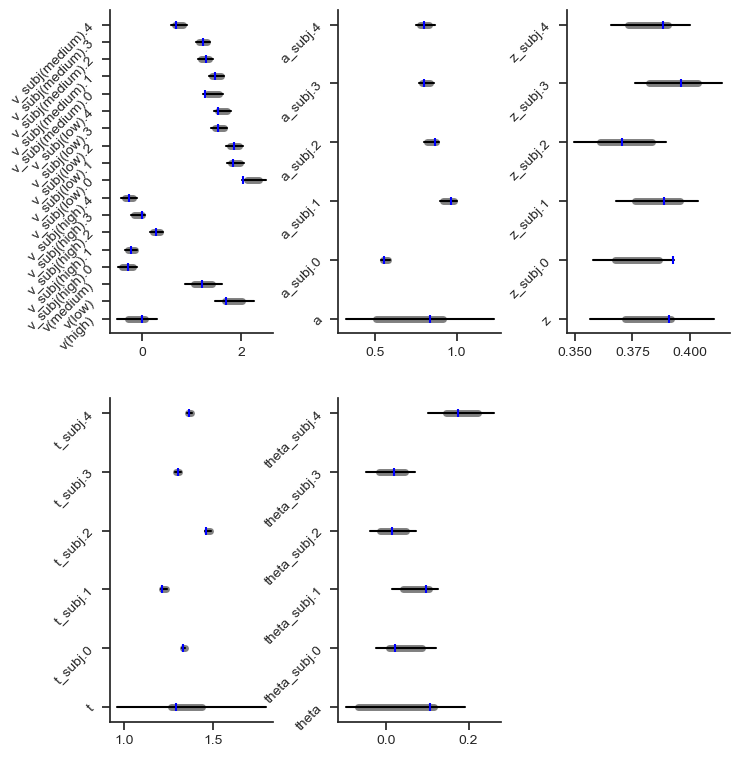

In [45]:
# Caterpillar Plot: (Parameters recovered ok?)
hddm.plotting.plot_caterpillar(
    hddm_model=hddmnn_model,
    ground_truth_parameter_dict=full_parameter_dict,
    figsize=(8, 8),
    columns=3,
)

plt.show()

passing
passing
passing
passing
passing


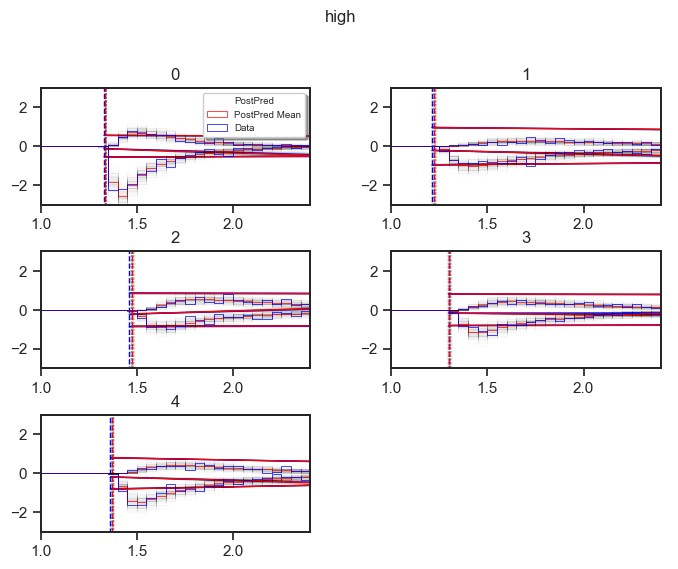

passing
passing
passing
passing
passing


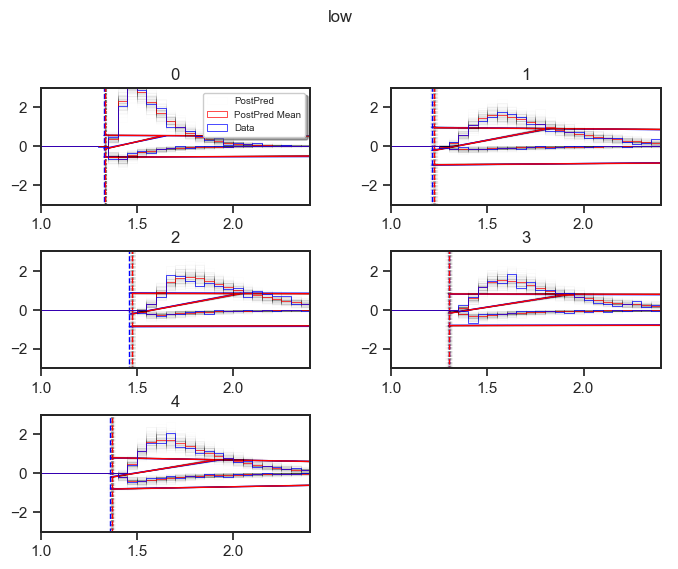

passing
passing
passing
passing
passing


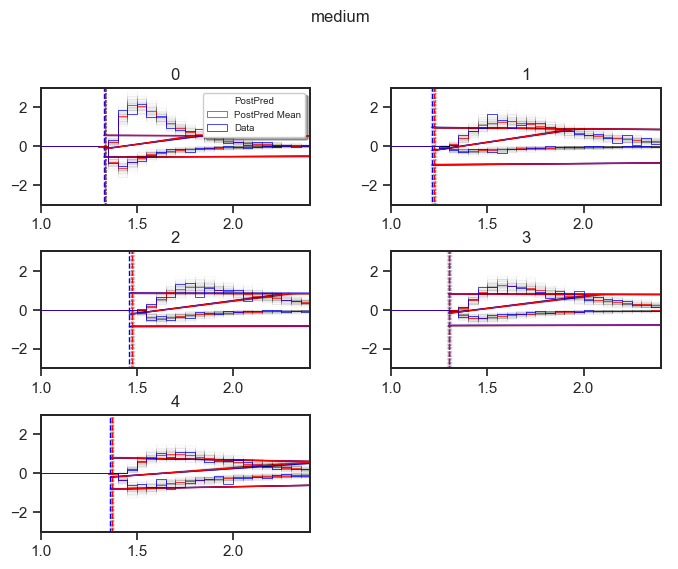

In [46]:
hddm.plotting.plot_posterior_predictive(
    model=hddmnn_model,
    columns=2,  # groupby = ['subj_idx'],
    figsize=(8, 6),
    value_range=np.arange(1, 2.5, 0.1),
    plot_func=hddm.plotting._plot_func_model,
    parameter_recovery_mode=True,
    **{
        "alpha": 0.01,
        "ylim": 3,
        "add_posterior_uncertainty_rts": True,
        "add_posterior_uncertainty_model": True,
        "samples": 200,
        "legend_fontsize": 7,
    }
)
plt.show()

## Section 5: Regressors

This section provides a simple working example using the Neural Networks with the Regression backend.
The regression back-end allows linking parameters to trial-by-trial covariates via a (general) linear model.

In [2]:
# Metadata
nmcmc = 1000
model = "angle"
n_samples_by_subject = 500

In [8]:
from hddm.simulators.hddm_dataset_generators import simulator_h_c

data, full_parameter_dict = simulator_h_c(
    n_subjects=5,
    n_samples_by_subject=n_samples_by_subject,
    model=model,
    p_outlier=0.00,
    conditions=None,
    depends_on=None,
    regression_models=["t ~ 1 + covariate_name", "v ~ 1 + covariate_name"],
    regression_covariates={"covariate_name": {"type": "continuous", "range": (0, 1)}},
    group_only_regressors=False,
    group_only=None,
    fixed_at_default=None,
)

In [9]:
# Set up the regressor a regressor:
reg_model_v = {"model": "v ~ 1 + covariate_name", "link_func": lambda x: x}
reg_model_t = {"model": "t ~ 1 + covariate_name", "link_func": lambda x: x}
reg_descr = [reg_model_t, reg_model_v]

In [10]:
# Make HDDM model
hddmnn_reg = hddm.HDDMnnRegressor(
    data,
    reg_descr,
    include=hddm.simulators.model_config[model]["hddm_include"],
    model=model,
    informative=False,
    p_outlier=0.0,
)

Supplied model_config specifies params_std_upper for  z as  None.
Changed to 10


In [11]:
# Sample
hddmnn_reg.sample(nmcmc, burn=100)

 [-----------------100%-----------------] 1001 of 1000 complete in 369.4 sec

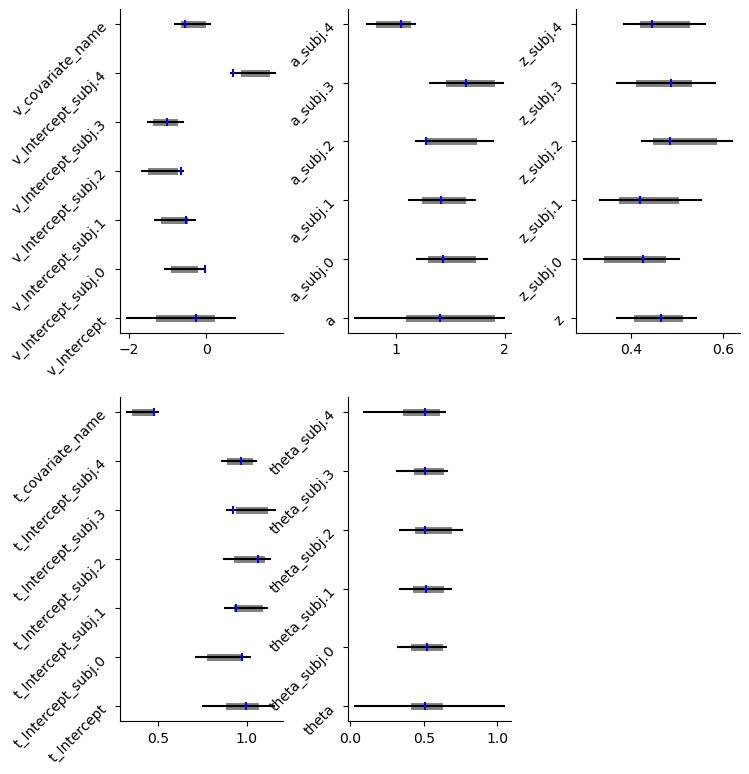

In [12]:
# Caterpillar Plot: (Parameters recovered ok?)
hddm.plotting.plot_caterpillar(
    hddm_model=hddmnn_reg,
    ground_truth_parameter_dict=full_parameter_dict,
    figsize=(8, 8),
    columns=3,
)

plt.show()

## Section 6: Stim Coding

You can read more about **stimulus coding** in the [documentation](https://hddm.readthedocs.io/en/latest/howto.html?highlight=stimulus%20coding#code-subject-responses).

Here just an example. 

In [53]:
# Metadata
nmcmc = 300
model = "ddm"
n_samples_by_condition = 500
split_param = "v"

In [54]:
sim_data_stimcoding, parameter_dict = hddm.simulators.simulator_stimcoding(
    model=model, split_by=split_param, drift_criterion=0.3, n_trials_per_condition=500
)

In [55]:
sim_data_stimcoding

,rt,response,stim,v,a,z,t,subj_idx
0,3.190470,1.0,1,0.834704,2.426857,0.417932,1.507448,none
1,3.942454,1.0,1,0.834704,2.426857,0.417932,1.507448,none
2,4.186436,1.0,1,0.834704,2.426857,0.417932,1.507448,none
3,2.205442,1.0,1,0.834704,2.426857,0.417932,1.507448,none
4,4.669401,1.0,1,0.834704,2.426857,0.417932,1.507448,none
...,...,...,...,...,...,...,...,...
495,11.207737,0.0,2,-0.234704,2.426857,0.417932,1.507448,none
496,10.334385,1.0,2,-0.234704,2.426857,0.417932,1.507448,none
497,7.077227,0.0,2,-0.234704,2.426857,0.417932,1.507448,none
498,8.740107,1.0,2,-0.234704,2.426857,0.417932,1.507448,none


In [56]:
parameter_dict

{'v': -0.5347036843723503,
 'a': 2.426856838254428,
 'z': 0.4179319892615798,
 't': 1.5074477307220377,
 'dc': 0.3}

In [57]:
hddmnn_model = hddm.HDDMnnStimCoding(
    sim_data_stimcoding,
    include=hddm.simulators.model_config[model]["hddm_include"],
    model=model,
    stim_col="stim",
    p_outlier=0.0,
    split_param=split_param,
    informative=False,
    drift_criterion=True,
)

In [58]:
hddmnn_model.sample(nmcmc, burn=100)

 [-----------------100%-----------------] 300 of 300 complete in 32.4 sec

In [59]:
hddmnn_model.gen_stats()

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
v,-0.539954,0.0155719,-0.572298,-0.549469,-0.540782,-0.528279,-0.508065,0.00112267
a,2.49136,0.00895635,2.47002,2.48866,2.49422,2.49799,2.49988,0.000770613
z,0.4031,0.0118855,0.37898,0.397112,0.40288,0.409666,0.431941,0.000958058
t,1.48852,0.035718,1.41497,1.46917,1.48828,1.51355,1.56092,0.00286112
dc,0.348321,0.0202259,0.30703,0.334826,0.349703,0.361927,0.386422,0.00170049


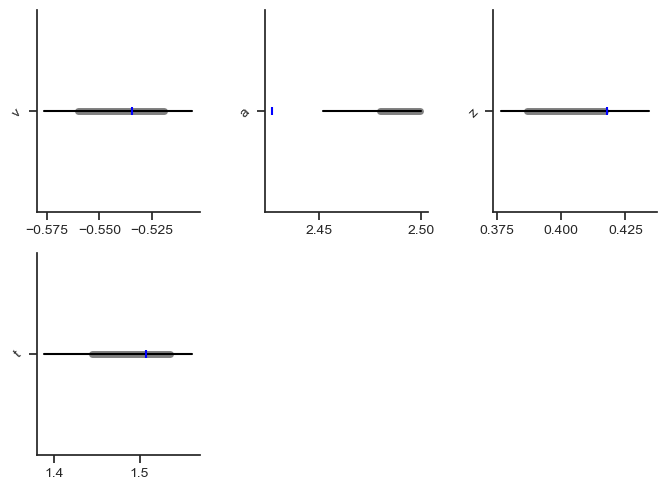

In [60]:
# Caterpillar Plot: (Parameters recovered ok?)
hddm.plotting.plot_caterpillar(
    hddm_model=hddmnn_model,
    ground_truth_parameter_dict=parameter_dict,
    figsize=(8, 5),
    columns=3,
)

plt.show()

**NOTE**: 

The `hddm.plotting.plot_posterior_predictive()` does not yet accept *stimcoding* data. This will be updated as soon as possible.

## Section 7: Model Recovery

A crucial exercise in statistical modeling concern **model comparison**. 

We are going to look at model recovery, in this section: Attempt to recover which model generated a given dataset from a set of *candidate models*. 

For the little model recovery study we conduct here, we generate data from the **weibull** model and fit the data once each to the  **weibull**, **angle** and **ddm** models.

We inspect the fits visually and then use the *DIC* (Deviance information criterion, lower is better :)), to check if we can recover the **true** model. 

In [61]:
# Metadata
model = "weibull"
n_samples = 300

In [62]:
# test regressors only False
# add p_outliers to the generator !
data, full_parameter_dict = simulator_h_c(
    n_subjects=1,
    n_samples_by_subject=n_samples,
    model=model,
    p_outlier=0.00,
    conditions=None,
    depends_on=None,
    regression_models=None,
    regression_covariates=None,
    group_only_regressors=False,
    group_only=None,
    fixed_at_default=None,
)

In [63]:
data

,rt,response,subj_idx,v,a,z,t,alpha,beta
0,4.204582,0.0,0,0.246969,1.470066,0.451724,1.397603,3.268501,4.603728
1,4.269577,1.0,0,0.246969,1.470066,0.451724,1.397603,3.268501,4.603728
2,4.404568,0.0,0,0.246969,1.470066,0.451724,1.397603,3.268501,4.603728
3,2.960620,1.0,0,0.246969,1.470066,0.451724,1.397603,3.268501,4.603728
4,2.223596,1.0,0,0.246969,1.470066,0.451724,1.397603,3.268501,4.603728
...,...,...,...,...,...,...,...,...,...
95,2.304595,1.0,0,0.246969,1.470066,0.451724,1.397603,3.268501,4.603728
96,3.067625,1.0,0,0.246969,1.470066,0.451724,1.397603,3.268501,4.603728
97,2.379594,1.0,0,0.246969,1.470066,0.451724,1.397603,3.268501,4.603728
98,3.991597,1.0,0,0.246969,1.470066,0.451724,1.397603,3.268501,4.603728


In [64]:
# Now we fit for each model:
hddmnn_model_weibull = hddm.HDDMnn(
    data,
    informative=False,
    model="weibull",
    p_outlier=0.0,
    include=hddm.simulators.model_config["weibull_cdf"]["hddm_include"],
    is_group_model=False,
)

hddmnn_model_angle = hddm.HDDMnn(
    data,
    model="angle",
    informative=False,
    p_outlier=0.0,
    include=hddm.simulators.model_config["angle"]["hddm_include"],
    is_group_model=False,
)

hddmnn_model_ddm = hddm.HDDMnn(
    data,
    informative=False,
    model="ddm",
    p_outlier=0.0,
    include=hddm.simulators.model_config["ddm"]["hddm_include"],
    is_group_model=False,
)

In [65]:
nmcmc = 1000
hddmnn_model_weibull.sample(nmcmc, burn=200)

hddmnn_model_angle.sample(nmcmc, burn=200)

hddmnn_model_ddm.sample(nmcmc, burn=200)

 [-----------------100%-----------------] 1000 of 1000 complete in 23.0 sec

### 7.1  Checking Model Fits Visually

Posterior Predictive: Do the 'Posterior Models' also make sense?

passing


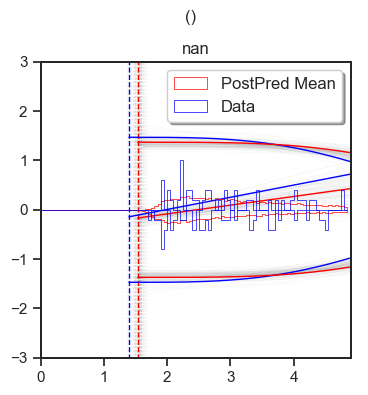

In [66]:
# WEIBULL
hddm.plotting.plot_posterior_predictive(
    model=hddmnn_model_weibull,
    columns=1,
    groupby=["subj_idx"],
    figsize=(4, 4),
    value_range=np.arange(0, 5, 0.1),
    plot_func=hddm.plotting._plot_func_model,
    parameter_recovery_mode=True,
    **{
        "alpha": 0.01,
        "ylim": 3,
        "add_posterior_uncertainty_model": True,
        "add_posterior_uncertainty_rts": False,
        "add_posterior_mean_rts": True,
        "samples": 200,
    }
)
plt.show()

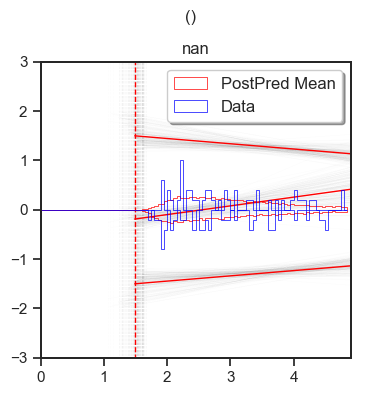

In [67]:
# ANGLE
hddm.plotting.plot_posterior_predictive(
    model=hddmnn_model_angle,
    columns=1,
    groupby=["subj_idx"],
    figsize=(4, 4),
    value_range=np.arange(0, 5, 0.1),
    plot_func=hddm.plotting._plot_func_model,
    parameter_recovery_mode=False,
    **{
        "alpha": 0.01,
        "ylim": 3,
        "add_posterior_uncertainty_model": True,
        "add_posterior_uncertainty_rts": False,
        "add_posterior_mean_rts": True,
        "samples": 200,
    }
)
plt.show()

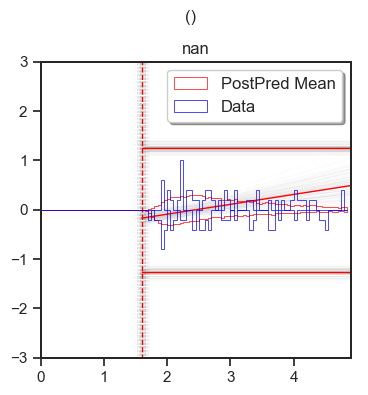

In [68]:
# DDM
hddm.plotting.plot_posterior_predictive(
    model=hddmnn_model_ddm,
    columns=1,
    groupby=["subj_idx"],
    figsize=(4, 4),
    value_range=np.arange(0, 5, 0.1),
    plot_func=hddm.plotting._plot_func_model,
    parameter_recovery_mode=False,
    **{
        "alpha": 0.01,
        "ylim": 3,
        "add_posterior_uncertainty_model": True,
        "add_posterior_uncertainty_rts": False,
        "add_posterior_mean_rts": True,
        "samples": 200,
    }
)
plt.show()

### 7.2 Comparing DIC's 

In [69]:
hddmnn_model_weibull.dic

414.65114936828616

In [70]:
hddmnn_model_angle.dic

415.8001557922363

In [71]:
hddmnn_model_ddm.dic

418.04479835510256

**Fingers crossed** (this was a random run after all), the DIC usually gives us a result that conforms with the intuition we get from looking at the model plots. 

## Section 8: Real Data!

In [72]:
# Metadata
nmcmc = 1000
burn = 500
model = "angle"

### 8.1 Load and Pre-process dataset

In [73]:
# Load one of the datasets shipping with HDDM
cav_data = hddm.load_csv(hddm.__path__[0] + "/examples/cavanagh_theta_nn.csv")

In [74]:
cav_data

,subj_idx,stim,rt,response,theta,dbs,conf
0,0,LL,1.210,1.0,0.656275,1,HC
1,0,WL,1.630,1.0,-0.327889,1,LC
2,0,WW,1.030,1.0,-0.480285,1,HC
3,0,WL,2.770,1.0,1.927427,1,LC
4,0,WW,1.140,0.0,-0.213236,1,HC
...,...,...,...,...,...,...,...
3983,13,LL,1.450,0.0,-1.237166,0,HC
3984,13,WL,0.711,1.0,-0.377450,0,LC
3985,13,WL,0.784,1.0,-0.694194,0,LC
3986,13,LL,2.350,0.0,-0.546536,0,HC


### 8.2 Basic Condition Split Model

In [75]:
hddmnn_model_cav = hddm.HDDMnn(
    cav_data,
    model=model,
    informative=False,
    include=hddm.simulators.model_config[model]["hddm_include"],
    p_outlier=0.05,
    is_group_model=False,
    depends_on={"v": "stim"},
)

In [76]:
hddmnn_model_cav.sample(nmcmc, burn=burn)

 [-----------------100%-----------------] 1000 of 1000 complete in 243.4 sec

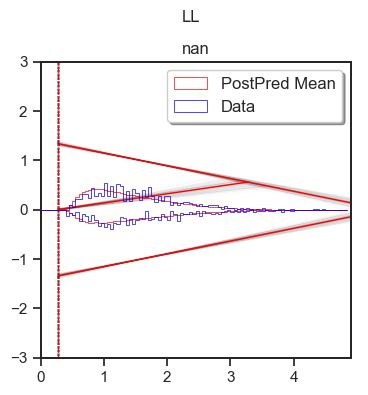

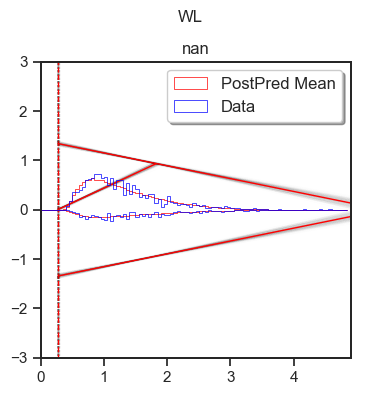

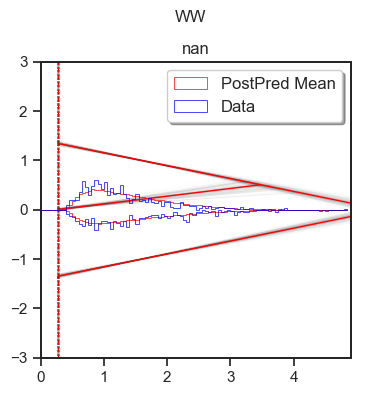

In [77]:
hddm.plotting.plot_posterior_predictive(
    model=hddmnn_model_cav,
    columns=1,
    figsize=(4, 4),
    value_range=np.arange(0, 5, 0.1),
    plot_func=hddm.plotting._plot_func_model,
    parameter_recovery_mode=False,
    **{
        "alpha": 0.01,
        "ylim": 3,
        "add_posterior_uncertainty_model": True,
        "add_posterior_uncertainty_rts": False,
        "add_posterior_mean_rts": True,
        "samples": 200,
    }
)
plt.show()

### 8.3 Basic Hierarchical Model

In [78]:
hddmnn_model_cav = hddm.HDDMnn(
    cav_data,
    model=model,
    informative=False,
    include=hddm.simulators.model_config[model]["hddm_include"],
    is_group_model=True,
    p_outlier=0.05,
)

In [79]:
hddmnn_model_cav.sample(nmcmc, burn=burn)

 [-----------------100%-----------------] 1000 of 1000 complete in 471.3 sec

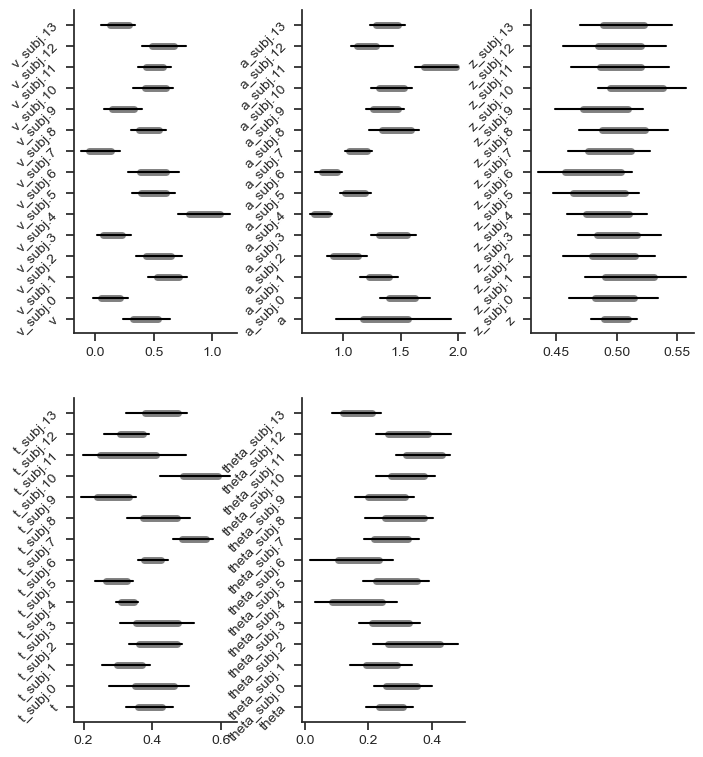

In [80]:
# Caterpillar Plot: (Parameters recovered ok?)
hddm.plotting.plot_caterpillar(hddm_model=hddmnn_model_cav, figsize=(8, 8), columns=3)

plt.show()

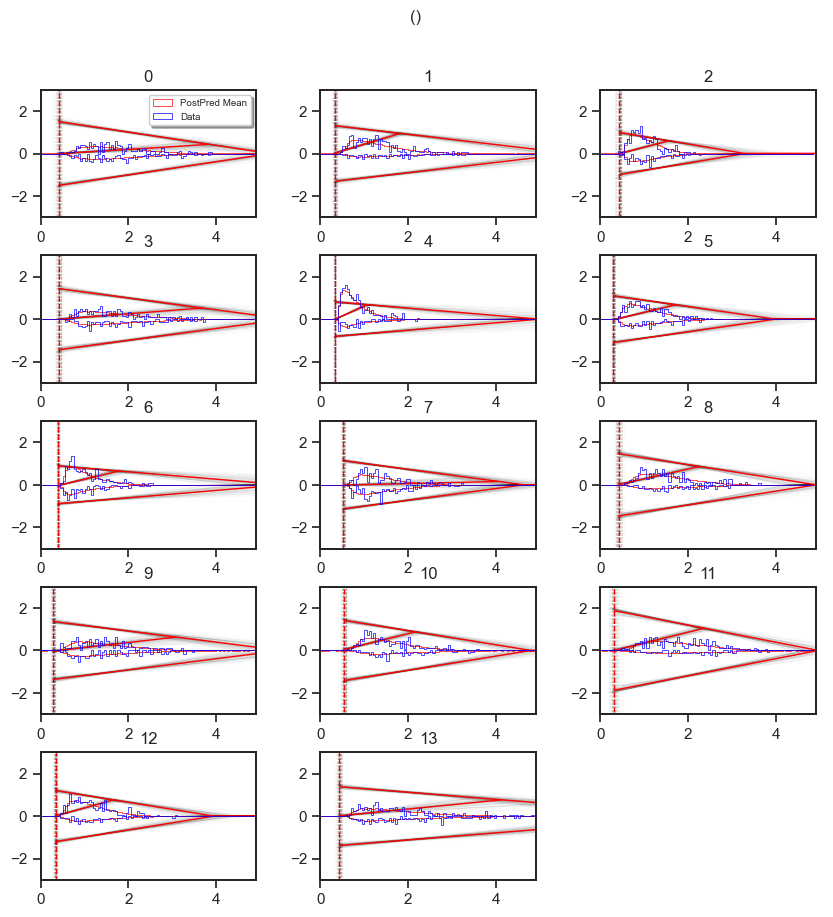

In [81]:
hddm.plotting.plot_posterior_predictive(
    model=hddmnn_model_cav,
    columns=3,
    figsize=(10, 10),
    value_range=np.arange(0, 5, 0.1),
    plot_func=hddm.plotting._plot_func_model,
    parameter_recovery_mode=False,
    **{
        "alpha": 0.01,
        "ylim": 3,
        "add_posterior_uncertainty_model": True,
        "add_posterior_uncertainty_rts": False,
        "add_posterior_mean_rts": True,
        "samples": 200,
        "legend_fontsize": 7,
        "subplots_adjust": {"top": 0.9, "hspace": 0.3, "wspace": 0.3},
    }
)
plt.show()

### Note

This is just an example. The angle model might not be the best choice here, and we are moreover ignoring the supplied conditions. 

## Section 9: Accessing the Neural Network Directly

The ```network_inspectors``` module allows you to inspect the LANs directly.

### 9.1 Direct access to batch predictions

 

You can use the ```hddm.network_inspectors.get_torch_mlp()``` function to access network predictions.

In [82]:
model = "angle"

In [83]:
lan_angle = hddm.network_inspectors.get_torch_mlp(model=model)

Let's predict some likelihoods !

In [84]:
# Make some random parameter set
parameter_df = hddm.simulators.make_parameter_vectors_nn(
    model=model, param_dict=None, n_parameter_vectors=1
)
parameter_matrix = np.tile(np.squeeze(parameter_df.values), (200, 1))

# Initialize network input
network_input = np.zeros(
    (parameter_matrix.shape[0], parameter_matrix.shape[1] + 2)
)  # Note the + 2 on the right --> we append the parameter vectors with reaction times (+1 columns) and choices (+1 columns)

# Add reaction times
network_input[:, -2] = np.linspace(0, 3, parameter_matrix.shape[0])

# Add choices
network_input[:, -1] = np.repeat(np.random.choice([-1, 1]), parameter_matrix.shape[0])

# Convert to float
network_input = network_input.astype(np.float32)
# Show example output
print(lan_angle(network_input)[:10])  # printing the first 10 outputs
print(lan_angle(network_input).shape)  # original shape of output

[[-2.9323568]
 [ 2.078088 ]
 [ 0.4104141]
 [-0.5943402]
 [-1.1136726]
 [-1.6901499]
 [-2.3512228]
 [-3.080151 ]
 [-3.8215086]
 [-4.4257374]]
(200, 1)


### 9.2 Plotting Utilities

HDDM provides two plotting function to investigate the network outputs directly. The ```kde_vs_lan_likelihoods()``` plot and the ```lan_manifold()``` plot. 

#### 9.2.1 ```kde_vs_lan_likelihoods()```

The ```kde_vs_lan_likelihoods()``` plot allows you to check the likelihoods produced by a LAN against Kernel Density Estimates (KDEs) from model simulations.
You can supply a panda ```DataFrame``` that holds parameter vectors as rows.  


In [85]:
# Make some parameters
parameter_df = hddm.simulators.make_parameter_vectors_nn(
    model=model, param_dict=None, n_parameter_vectors=10
)

In [86]:
parameter_df

,v,a,z,t,theta
0,2.149626,1.684902,0.232222,0.641663,-0.070030
1,1.817911,0.776330,0.535083,0.006625,1.069452
2,-0.908428,0.654107,0.301445,1.560911,0.396448
3,-0.022136,1.140235,0.479664,0.757727,1.316409
4,2.281230,0.366558,0.409224,1.908211,1.059872
5,1.067632,1.228020,0.337573,1.447155,0.083665
6,2.022131,1.254037,0.262336,0.416462,0.512724
7,-1.974657,0.793536,0.791707,0.591319,1.036441
8,-2.002436,1.382722,0.442411,0.074192,0.356522
9,-2.757462,0.402900,0.738999,0.755093,1.334423


1 of 10
2 of 10
3 of 10
4 of 10
5 of 10
6 of 10
7 of 10
8 of 10
9 of 10
10 of 10


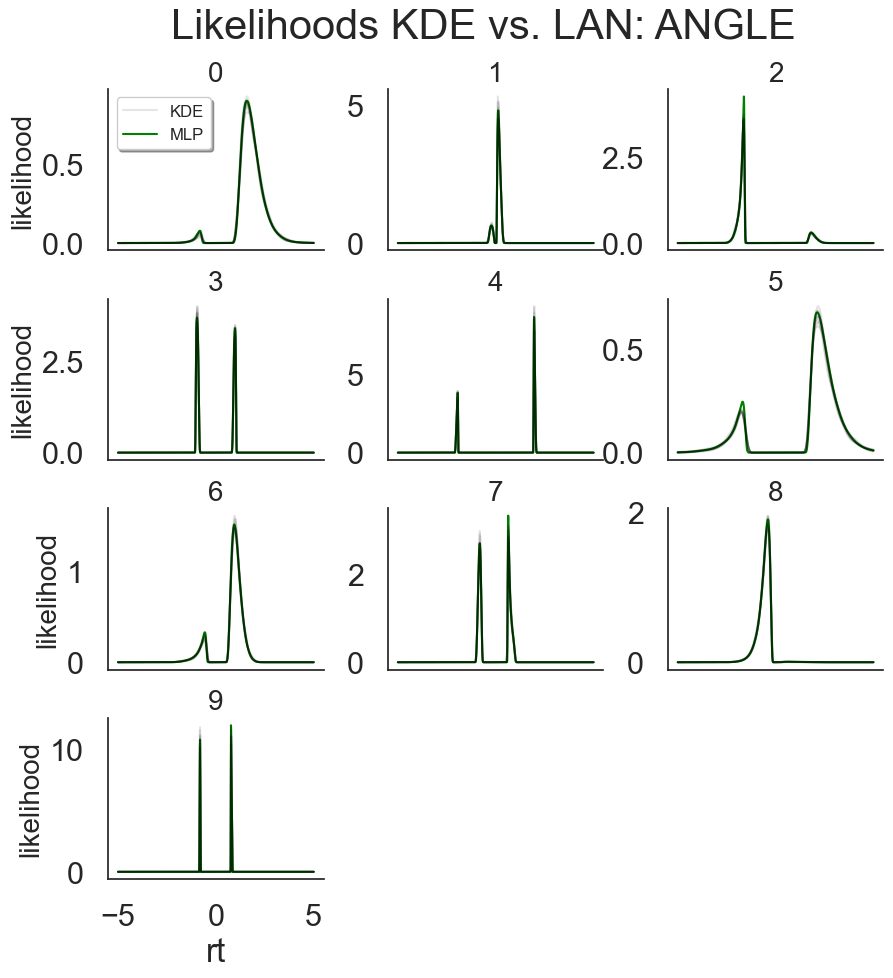

In [87]:
hddm.network_inspectors.kde_vs_lan_likelihoods(
    parameter_df=parameter_df, model=model, cols=3, n_samples=2000, n_reps=10, show=True
)

#### 9.2.2 ```lan_manifold()```

Lastly, you can use the ```lan_manifold()``` plot to investigate the LAN likelihoods over a range of parameters. 

The idea is to use a base parameter vector and vary one of the parameters in a prespecificed range. 

This plot can be informative if you would like to understand better how a parameter affects model behavior.

In [88]:
# Make some parameters
parameter_df = hddm.simulators.make_parameter_vectors_nn(
    model=model, param_dict=None, n_parameter_vectors=1
)

In [89]:
parameter_df

,v,a,z,t,theta
0,-2.218164,0.889863,0.254979,0.707028,0.040745


Using only the first row of the supplied parameter array !


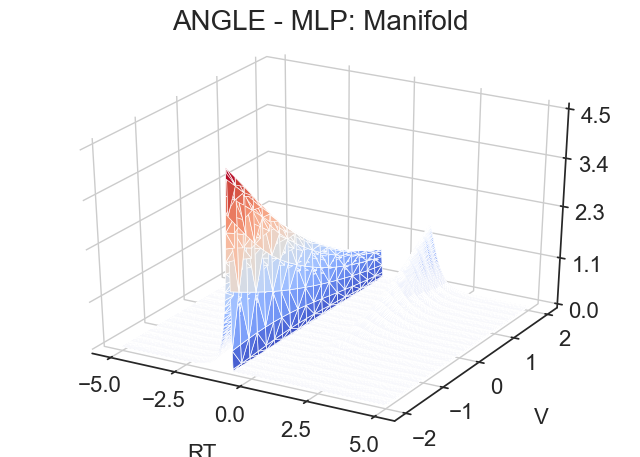

In [90]:
# Now plotting
hddm.network_inspectors.lan_manifold(
    parameter_df=parameter_df,
    vary_dict={"v": np.linspace(-2, 2, 20)},
    model=model,
    n_rt_steps=300,
    fig_scale=1.0,
    max_rt=5,
    save=True,
    show=True,
)

Hopefully this tutorial proves as a useful starting point for your application.